red neuronal
Iteracion 0 - Perdida: 0.7917, Prec. Train: 0.5312, Prec. Val: 0.5012
Iteracion 1000 - Perdida: 0.5416, Prec. Train: 0.7812, Prec. Val: 0.6975
Iteracion 2000 - Perdida: 0.5809, Prec. Train: 0.6562, Prec. Val: 0.7200
Iteracion 3000 - Perdida: 0.5080, Prec. Train: 0.8125, Prec. Val: 0.7275
Iteracion 4000 - Perdida: 0.4977, Prec. Train: 0.8125, Prec. Val: 0.7638
Iteracion 5000 - Perdida: 0.3931, Prec. Train: 0.8125, Prec. Val: 0.7812
Iteracion 6000 - Perdida: 0.5018, Prec. Train: 0.6875, Prec. Val: 0.7850
Iteracion 7000 - Perdida: 0.5218, Prec. Train: 0.8125, Prec. Val: 0.7762
Iteracion 8000 - Perdida: 0.4036, Prec. Train: 0.8125, Prec. Val: 0.7837
Iteracion 9000 - Perdida: 0.2244, Prec. Train: 0.9688, Prec. Val: 0.7987
Iteracion 10000 - Perdida: 0.4450, Prec. Train: 0.8438, Prec. Val: 0.8087
Iteracion 11000 - Perdida: 0.4548, Prec. Train: 0.7500, Prec. Val: 0.7925
Iteracion 12000 - Perdida: 0.5150, Prec. Train: 0.7500, Prec. Val: 0.8075
Iteracion 13000 - Perdida: 0.3041, Pre

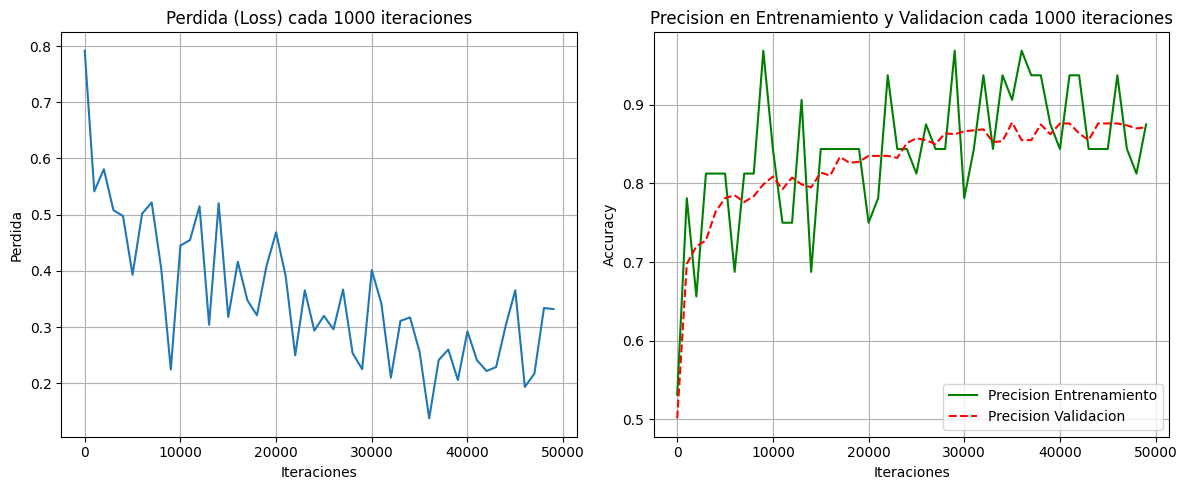


 pruebo la prediccion
Manzana de CALIDAD BUENA (Probabilidad: 0.8932)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import time

# --- CARGA Y PREPROCESAMIENTO DE MIS DATOS ---
# Aca cargo mi archivo CSV de las manzanas
df_processed = pd.read_csv("apple_actualizado.csv")

X = df_processed[['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']].values
y = df_processed['Quality_numeric'].values.reshape(-1, 1)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# El 80% es para entrenar (train) y el 20% para validar (val).
# El 'random_state=42' es un numero que elijo para que, cada vez que corra el codigo, la division sea la misma.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_t = X_train.T  
y_train_t = y_train.T  
X_val_t = X_val.T     
y_val_t = y_val.T     

# Estas son las cantidades de neuronas en cada capa
input_dim = X_train_t.shape[0] # Serian 7 caracteristicas (size, weight, etc.)
h1_dim = 16 # Primera capa oculta tiene 16 neuronas
h2_dim = 8  # Segunda capa oculta tiene 8 neuronas
output_dim = 1 # La capa de salida tiene 1 neurona (predice si la manzana es buena o mala)

# --- MIS FUNCIONES DE ACTIVACION Y SUS DERIVADAS ---
# La funcion Sigmoid: comprime cualquier valor entre 0 y 1. 
def sigmoid(x): return 1 / (1 + np.exp(-x))
# Derivada de Sigmoid: 
def sigmoid_deriv(x): s = sigmoid(x); return s * (1 - s)

# La funcion Relu: si es positivo, devuelve el mismo numero, si es negativo o cero, devuelve 0.
def relu(x): return np.maximum(0, x)
# Es 1 si x > 0, 0 si no.
def relu_deriv(x): return (x > 0).astype(float)

# --- INICIALIZACION DE PESOS Y SESGOS  ---
def init_pesos(input_dim, h1_dim, h2_dim, output_dim):
    np.random.seed(0) 

    # Pesos y sesgos de la capa 1 (Entrada a Oculta 1)
    W1 = np.random.rand(h1_dim, input_dim) * 2 - 1
    b1 = np.random.rand(h1_dim, 1) * 2 - 1

    # Pesos y sesgos de la capa 2 (Oculta 1 a Oculta 2)
    W2 = np.random.rand(h2_dim, h1_dim) * 2 - 1
    b2 = np.random.rand(h2_dim, 1) * 2 - 1

    # Pesos y sesgos de la capa de salida (Oculta 2 a Salida)
    W3 = np.random.rand(output_dim, h2_dim) * 2 - 1
    b3 = np.random.rand(output_dim, 1) * 2 - 1
    
    return W1, b1, W2, b2, W3, b3 

def forward_prop(X_input, W1, b1, W2, b2, W3, b3):
    # X_input aca ya viene transpuesta (caracteristicas, muestras)
    
    Z1 = W1 @ X_input + b1
    A1 = relu(Z1) # Aplico la funcion de activacion ReLU.

    Z2 = W2 @ A1 + b2
    A2 = relu(Z2)

    Z3 = W3 @ A2 + b3
    A3 = sigmoid(Z3) # Para la salida final, uso Sigmoid porque me da una probabilidad entre 0 y 1
    return Z1, A1, Z2, A2, Z3, A3 # devuelvo valores para el backpropagation

def backward_prop(Xb, yb, Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, batch_size):
    # Calculo el error en la capa de salida (dZ3).
    dZ3 = A3 - yb
    # Calculo como ajustar los pesos de la ultima capa (dW3).
    dW3 = (dZ3 @ A2.T) / batch_size
    # Calculo como ajustar el sesgo de la ultima capa (db3).
    db3 = np.sum(dZ3, axis=1, keepdims=True) / batch_size

    dA2 = W3.T @ dZ3
    dZ2 = dA2 * relu_deriv(Z2)
    dW2 = (dZ2 @ A1.T) / batch_size
    db2 = np.sum(dZ2, axis=1, keepdims=True) / batch_size

    dA1 = W2.T @ dZ2
    dZ1 = dA1 * relu_deriv(Z1)
    dW1 = (dZ1 @ Xb.T) / batch_size
    db1 = np.sum(dZ1, axis=1, keepdims=True) / batch_size

    return dW1, db1, dW2, db2, dW3, db3

# Parametros de entrenamiento
iteraciones = 50000
batch_size = 32
lr = 0.01 # Learning Rate

def entrenar_red(X_train_data, y_train_data, X_val_data, y_val_data, input_dim, h1_dim, h2_dim, output_dim, iteraciones, batch_size, lr):
    W1, b1, W2, b2, W3, b3 = init_pesos(input_dim, h1_dim, h2_dim, output_dim)
    
    loss_hist, acc_train_hist, acc_val_hist = [], [], []

    num_samples_train = X_train_data.shape[1] 

    for it in range(iteraciones):
        # Selecciono un mini-batch aleatorio de mis muestras.
        idx = np.random.choice(num_samples_train, size=batch_size, replace=False)
        Xb = X_train_data[:, idx] # caracteristicas del batch
        yb = y_train_data[:, idx] # etiquetas del batch

        # Le paso los pesos y sesgos actuales a la funcion forward_prop.
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(Xb, W1, b1, W2, b2, W3, b3)

        # Calculo la peridda
        loss = -np.mean(yb * np.log(A3 + 1e-8) + (1 - yb) * np.log(1 - A3 + 1e-8))

        # Calculo la precision
        acc_train = accuracy_score(yb.flatten(), (A3 > 0.5).astype(int).flatten())

        # Cada 1000 iteraciones, muestro el progreso y me fijo en el set de validacion.
        if it % 1000 == 0:
            _, _, _, _, _, val_preds = forward_prop(X_val_data, W1, b1, W2, b2, W3, b3)
            acc_val = accuracy_score(y_val_data.flatten(), (val_preds > 0.5).astype(int).flatten())

            loss_hist.append(loss)
            acc_train_hist.append(acc_train)
            acc_val_hist.append(acc_val)

            print(f"Iteracion {it} - Perdida: {loss:.4f}, Prec. Train: {acc_train:.4f}, Prec. Val: {acc_val:.4f}")

        # ---BACKPROPAGATION ---
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(Xb, yb, Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, batch_size)

        # --- ACTUALIZACION DE PESOS Y SESGOS ---
        W3 -= lr * dW3
        b3 -= lr * db3
        W2 -= lr * dW2
        b2 -= lr * db2
        W1 -= lr * dW1
        b1 -= lr * db1
            
    return W1, b1, W2, b2, W3, b3, loss_hist, acc_train_hist, acc_val_hist

# --------------------------------------------
# ENTRENAMIENTO Y LOS RESULTADOS FINALES
# --------------------------------------------
print("red neuronal")
start = time.time() # cuanto tarda el entrenamiento.

W1_final, b1_final, W2_final, b2_final, W3_final, b3_final, losses, accs_train, accs_val = \
    entrenar_red(X_train_t, y_train_t, X_val_t, y_val_t, input_dim, h1_dim, h2_dim, output_dim, iteraciones, batch_size, lr)

# Calculo la precision final en los sets de entrenamiento y validacion
train_preds = forward_prop(X_train_t, W1_final, b1_final, W2_final, b2_final, W3_final, b3_final)[-1]
val_preds = forward_prop(X_val_t, W1_final, b1_final, W2_final, b2_final, W3_final, b3_final)[-1]

train_acc = accuracy_score(y_train_t.flatten(), (train_preds > 0.5).astype(int).flatten())
val_acc = accuracy_score(y_val_t.flatten(), (val_preds > 0.5).astype(int).flatten())

print("\n rtas")
print(f"Precision en el set de entrenamiento: {train_acc:.4f}")
print(f"Precision en el set de validacion: {val_acc:.4f}")
print(f"Mi red tardo: {time.time() - start:.2f} segundos en entrenar.") 

# --------------------------------------------
# GRAFICOS 
# --------------------------------------------
plt.figure(figsize=(12, 5)) 

plt.subplot(1, 2, 1) 
plt.plot(np.arange(0, iteraciones, 1000), losses) 
plt.title("Perdida (Loss) cada 1000 iteraciones") 
plt.xlabel("Iteraciones") 
plt.ylabel("Perdida") 
plt.grid(True) 

plt.subplot(1, 2, 2) 
plt.plot(np.arange(0, iteraciones, 1000), accs_train, label='Precision Entrenamiento', color='green')
plt.plot(np.arange(0, iteraciones, 1000), accs_val, label='Precision Validacion', color='red', linestyle='--')
plt.title("Precision en Entrenamiento y Validacion cada 1000 iteraciones")
plt.xlabel("Iteraciones")
plt.ylabel("Accuracy")
plt.legend() 
plt.grid(True)

plt.tight_layout() 
plt.show() 

# --------------------------------------------
# EJEMPLO DE PREDICCION CON UN NUEVO DATO
# --------------------------------------------
def predict_single_sample(input_data_dict, W1_final, b1_final, W2_final, b2_final, W3_final, b3_final):
    # Convierto el diccionario que le pasamos a un DataFrame.
    df_single = pd.DataFrame([input_data_dict])
    
    # vuekvo a normalizar
    features_order = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']
    # IMPORTANTE: Usar el mismo scaler que se usó para entrenar
    X_single = scaler.transform(df_single[features_order].values)
    
    X_single_t = X_single.T
    
    # Hago un forward propagation para obtener la prediccion
    prediction = forward_prop(X_single_t, W1_final, b1_final, W2_final, b2_final, W3_final, b3_final)[-1]
    
    return prediction[0, 0]

# Funcion para decir si la manzana es "buena" o "mala" basandose en la probabilidad.
def predecir_si_buena_manzana(input_data_dict, W1_final, b1_final, W2_final, b2_final, W3_final, b3_final):
    prob_buena = predict_single_sample(input_data_dict, W1_final, b1_final, W2_final, b2_final, W3_final, b3_final)
    if prob_buena > 0.5:
        return f"Manzana de CALIDAD BUENA (Probabilidad: {prob_buena:.4f})"
    else:
        return f"Manzana de CALIDAD MALA (Probabilidad: {prob_buena:.4f})"

# Aca pongo un ejemplo de una nueva manzana para probar.
print("\n pruebo la prediccion")
datos_ejemplo = {
    'Size': 0.7, 'Weight': 0.6, 'Sweetness': 0.8, 'Crunchiness': 0.7,
    'Juiciness': 0.8, 'Ripeness': 0.9, 'Acidity': 0.2
}

resultado_prediccion = predecir_si_buena_manzana(datos_ejemplo, W1_final, b1_final, W2_final, b2_final, W3_final, b3_final)
print(resultado_prediccion)

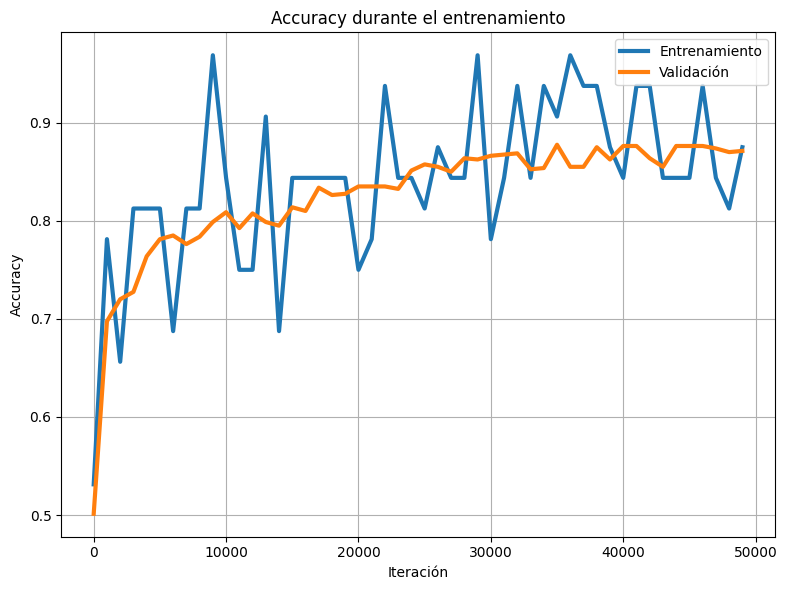

In [68]:
fmt_train = {'color': 'tab:blue', 'ls': 'solid', 'lw': 3}
fmt_val = {'color': 'tab:orange', 'ls': 'solid', 'lw': 3}

steps = np.arange(0, len(accs_train) * 1000, 1000)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(steps, accs_train, label='Entrenamiento', **fmt_train)
ax.plot(steps, accs_val, label='Validación', **fmt_val)

ax.grid(True)
ax.legend()
ax.set_title('Accuracy durante el entrenamiento')
ax.set_xlabel('Iteración')
ax.set_ylabel('Accuracy')
fig.tight_layout()
plt.show()

In [69]:
# --------------------------------------------
#PREDICCIONES CON MUESTRAS ALEATORIAS
# --------------------------------------------
print("\n predicciones con 10 manzanas aleatorias")

sample_rows = df_processed.sample(n=10, random_state=1) 

X_sample_raw = sample_rows[['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']].values
y_real = sample_rows['Quality_numeric'].values

for i, (original_features, true_label) in enumerate(zip(X_sample_raw, y_real)):
    # normalizo la fila d caracteristicas
    X_single_normalized = scaler.transform(original_features.reshape(1, -1)) 

    # trasnpongo para que coincida con el formato de entrada de forward_prop (num_features, 1)
    X_single_t = X_single_normalized.T

    prob_prediction = forward_prop(X_single_t, W1_final, b1_final, W2_final, b2_final, W3_final, b3_final)[-1]
    
    # clasificacion binaria
    binary_prediction = (prob_prediction > 0.5).astype(int)

    print(f"\nManzana de muestra {i+1}:")
    print(f"   caracteristicas: {original_features}") 
    print(f"   probabilidad predicha (Calidad Buena): {prob_prediction[0,0]:.4f}")
    print(f"   prediccion de la red (0=Mala, 1=Buena): {binary_prediction[0,0]}")
    print(f"   calidad real de la manzana: {int(true_label)}") 

    if binary_prediction[0,0] == int(true_label):
        print("prediccion correcta")
    else:
        print("prediccion incorrecta :(")



 predicciones con 10 manzanas aleatorias

Manzana de muestra 1:
   caracteristicas: [-1.19355172 -1.48454888 -1.68280142 -0.25582627  1.88829673  1.36956133
  1.64019792]
   probabilidad predicha (Calidad Buena): 0.0027
   prediccion de la red (0=Mala, 1=Buena): 0
   calidad real de la manzana: 0
prediccion correcta

Manzana de muestra 2:
   caracteristicas: [-1.3784287  -1.09546502  1.55283841  2.1337372   1.70640912 -0.14060961
 -1.42972353]
   probabilidad predicha (Calidad Buena): 0.6216
   prediccion de la red (0=Mala, 1=Buena): 1
   calidad real de la manzana: 1
prediccion correcta

Manzana de muestra 3:
   caracteristicas: [-1.02350156 -1.74575056  1.36952746 -0.27713368 -0.37500112  0.72821983
 -1.68465921]
   probabilidad predicha (Calidad Buena): 0.5314
   prediccion de la red (0=Mala, 1=Buena): 1
   calidad real de la manzana: 0
prediccion incorrecta :(

Manzana de muestra 4:
   caracteristicas: [ 0.58669457 -1.3338859  -0.29202348  1.13649496 -1.93756378 -0.40091978
 -0.92

In [70]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import time

mlp = MLPClassifier(hidden_layer_sizes=(16, 8), activation='relu', solver='sgd',
                    learning_rate_init=0.01, max_iter=50000, random_state=42, verbose=False)

print("Entrenando red neuronal con scikit-learn...")
start_skl = time.time()
mlp.fit(X_train, y_train.ravel()) # .ravel() para convertir y_train a un array 1D
end_skl = time.time()
print(f"Tiempo total de entrenamiento con scikit-learn: {end_skl - start_skl:.2f} segundos")

# Predecir y evaluar
y_train_pred_skl = mlp.predict(X_train)
y_val_pred_skl = mlp.predict(X_val)

train_acc_skl = accuracy_score(y_train, y_train_pred_skl)
val_acc_skl = accuracy_score(y_val, y_val_pred_skl)

print("\n--- Resultados scikit-learn ---")
print(f"Precision en entrenamiento (scikit-learn): {train_acc_skl:.4f}")
print(f"Precision en validación (scikit-learn): {val_acc_skl:.4f}")

Entrenando red neuronal con scikit-learn...
Tiempo total de entrenamiento con scikit-learn: 1.11 segundos

--- Resultados scikit-learn ---
Precision en entrenamiento (scikit-learn): 0.8656
Precision en validación (scikit-learn): 0.8712
